In [36]:
import cesium
from cesium import featurize, data_management, features, time_series
import os
import sys
import pandas as pd
import glob
import numpy as np
import tarfile
import joblib
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kendalltau
from sklearn.ensemble import RandomForestClassifier

sns.set()
%matplotlib inline

plt.rcParams['figure.figsize'] = (10.0, 8.0)

In [19]:
# Construct header file

LC_type_column = np.array([None, 'RR_Lyrae_FM', 'RR_Lyrae_FO', None, 'Beta_Persei', 'W_Ursae_Maj', 'Delta_Scuti'])

df = pd.read_csv('linear.meta.csv', usecols=['file', 'class'])
df['class'] = LC_type_column[df['class']]
df['file'] = df['file'].apply(lambda el: el.replace('linear_lcs/', '').replace('.csv', ''))

df = df.rename(columns={'class': 'target', 'file': 'filename'})

df.to_csv('linear_header.dat', index=False)

df.head()

filename       target
0    29848  RR_Lyrae_FM
1    32086  RR_Lyrae_FM
2    50402  RR_Lyrae_FM
3    61011  RR_Lyrae_FM
4    62892  RR_Lyrae_FM

In [25]:
# Remove invalid header row in TS files

if not os.path.exists('./linear_lcs_formatted'):
    os.mkdir('./linear_lcs_formatted')

for fpath in glob.glob('linear_lcs/*.csv'):
    data = np.loadtxt(fpath, skiprows=1, delimiter=',')
    np.savetxt(fpath.replace('linear_lcs', 'linear_lcs_formatted'), data, delimiter=',')

In [12]:
# Parse TS data
ts_paths = data_management.parse_and_store_ts_data(data_path='linear_lcs_formatted.tar.gz', 
                                                   header_path='linear_header.dat',
                                                   output_dir='/tmp', cleanup_archive=False, cleanup_header=False)

## Generate survey features and compute prediction score

In [26]:
# Generate survey features
linear_survey_features, labels = featurize.featurize_ts_files(ts_paths=ts_paths, 
                                                              features_to_use=features.CADENCE_FEATS)

linear_survey_features = featurize.impute_featureset(linear_survey_features)
linear_survey_features.head()

/home/arien/projects/cesium/cesium/features/cadence_features.py:12: RuntimeWarning: divide by zero encountered in true_divide
  return (cads[2:] + cads[:-2]) / (cads[1:-1] - cads[:-2])
/home/arien/projects/cesium/cesium/features/cadence_features.py:12: RuntimeWarning: divide by zero encountered in true_divide
  return (cads[2:] + cads[:-2]) / (cads[1:-1] - cads[:-2])
/home/arien/anaconda3/envs/survey_app2/lib/python3.6/site-packages/numpy/core/_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/home/arien/anaconda3/envs/survey_app2/lib/python3.6/site-packages/numpy/core/_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/home/arien/projects/cesium/cesium/features/cadence_features.py:12: RuntimeWarning: divide by zero encountered in true_divide
  return (cads[2:] + cads[:-2]) / (cads[1:-1] - cads[:-2])
/home/arien/anaconda3/envs/survey_app2/lib/python3.6/site-packages/numpy/core/_meth

In [41]:
# Load survey model and do predictions
model = joblib.load('../../survey_classifier_data/data/survey_classifier.pkl')
preds = model.predict(linear_survey_features)
score = np.mean(preds == 'LINEAR')
print(score)

0.998847040738


## Generate science features

In [13]:
# Generate science features
linear_science_features, labels = featurize.featurize_ts_files(ts_paths=ts_paths, 
                                                               features_to_use=(features.GENERAL_FEATS + 
                                                                                features.LOMB_SCARGLE_FEATS))

linear_science_features = featurize.impute_featureset(linear_science_features)
featurize.save_featureset(linear_science_features, 'linear_science_features.npz', labels=labels)
linear_science_features.head()

/home/arien/anaconda3/envs/survey_app2/lib/python3.6/site-packages/numpy/lib/npyio.py:665: UserWarning: Stored array in format 2.0. It can only beread by NumPy >= 1.9
  pickle_kwargs=pickle_kwargs)


feature  amplitude flux_percentile_ratio_mid20 flux_percentile_ratio_mid35  \
channel          0                           0                           0   
24249206    0.4200                    0.140490                    0.285522   
14142720    0.4890                    0.138918                    0.265605   
4958189     0.3460                    0.145272                    0.280296   
17626260    0.4965                    0.199384                    0.342400   
782055      0.3265                    0.220948                    0.435407   

feature  flux_percentile_ratio_mid50 flux_percentile_ratio_mid65  \
channel                            0                           0   
24249206                    0.459358                    0.650178   
14142720                    0.403875                    0.513639   
4958189                     0.458508                    0.641975   
17626260                    0.498096                    0.652906   
782055                      0.612101                    0.749112   

feature  flux_percentile_ratio_mid80    max_slope maximum   median  \
channel                            0            0       0        0   
24249206                    0.754818    27.341244  16.843  16.4610   
14142720                    0.738521  2247.311946  17.361  16.9360   
4958189                     0.881083   794.117649  15.911  15.3765   
17626260                    0.806965    81.766917  16.990  16.4430   
782055                      0.917197    15.305598  16.095  15.6580   

feature  median_absolute_deviation       ...       freq_signif_ratio_31  \
channel                          0       ...                          0   
24249206                    0.1480       ...                   0.463145   
14142720                    0.1480       ...                   0.543482   
4958189                     0.0595       ...                   0.276800   
17626260                    0.1070       ...                   0.403096   
782055                      0.1280       ...                   0.506914   

feature  freq_varrat freq_y_offset linear_trend medperc90_2p_p  \
channel            0             0            0              0   
24249206    0.000012      0.047163    -0.000020       1.943843   
14142720    0.000039      0.013582     0.000004       1.057547   
4958189     0.000011      0.040115    -0.000005       1.460408   
17626260    0.000015      0.009718     0.000034       0.992318   
782055      0.000012      0.015130    -0.000010       1.065208   

feature  p2p_scatter_2praw p2p_scatter_over_mad p2p_scatter_pfold_over_mad  \
channel                  0                    0                          0   
24249206          0.493799             0.435811                   0.361486   
14142720          0.815918             0.540541                   0.611486   
4958189           0.251946             1.025210                   0.504202   
17626260          0.957031             0.467290                   0.542056   
782055            0.416070             0.457031                   0.394531   

feature  p2p_ssqr_diff_over_var scatter_res_raw  
channel                       0               0  
24249206               0.428255        0.214742  
14142720               0.618630        0.321073  
4958189                1.104080        0.318545  
17626260               0.616209        0.327540  
782055                 0.694378        0.226688  

[5 rows x 70 columns]

In [3]:
linear_science_features, data = featurize.load_featureset('linear_science_features.npz')
labels = data['labels']
linear_science_features.head()

feature  amplitude flux_percentile_ratio_mid20 flux_percentile_ratio_mid35  \
channel          0                           0                           0   
24249206    0.4200                    0.140490                    0.285522   
14142720    0.4890                    0.138918                    0.265605   
4958189     0.3460                    0.145272                    0.280296   
17626260    0.4965                    0.199384                    0.342400   
782055      0.3265                    0.220948                    0.435407   

feature  flux_percentile_ratio_mid50 flux_percentile_ratio_mid65  \
channel                            0                           0   
24249206                    0.459358                    0.650178   
14142720                    0.403875                    0.513639   
4958189                     0.458508                    0.641975   
17626260                    0.498096                    0.652906   
782055                      0.612101                    0.749112   

feature  flux_percentile_ratio_mid80    max_slope maximum   median  \
channel                            0            0       0        0   
24249206                    0.754818    27.341244  16.843  16.4610   
14142720                    0.738521  2247.311946  17.361  16.9360   
4958189                     0.881083   794.117649  15.911  15.3765   
17626260                    0.806965    81.766917  16.990  16.4430   
782055                      0.917197    15.305598  16.095  15.6580   

feature  median_absolute_deviation       ...       freq_signif_ratio_31  \
channel                          0       ...                          0   
24249206                    0.1480       ...                   0.463145   
14142720                    0.1480       ...                   0.543482   
4958189                     0.0595       ...                   0.276800   
17626260                    0.1070       ...                   0.403096   
782055                      0.1280       ...                   0.506914   

feature  freq_varrat freq_y_offset linear_trend medperc90_2p_p  \
channel            0             0            0              0   
24249206    0.000012      0.047163    -0.000020       1.943843   
14142720    0.000039      0.013582     0.000004       1.057547   
4958189     0.000011      0.040115    -0.000005       1.460408   
17626260    0.000015      0.009718     0.000034       0.992318   
782055      0.000012      0.015130    -0.000010       1.065208   

feature  p2p_scatter_2praw p2p_scatter_over_mad p2p_scatter_pfold_over_mad  \
channel                  0                    0                          0   
24249206          0.493799             0.435811                   0.361486   
14142720          0.815918             0.540541                   0.611486   
4958189           0.251946             1.025210                   0.504202   
17626260          0.957031             0.467290                   0.542056   
782055            0.416070             0.457031                   0.394531   

feature  p2p_ssqr_diff_over_var scatter_res_raw  
channel                       0               0  
24249206               0.428255        0.214742  
14142720               0.618630        0.321073  
4958189                1.104080        0.318545  
17626260               0.616209        0.327540  
782055                 0.694378        0.226688  

[5 rows x 70 columns]

## Compute score and plot conf mx for noisified LINEAR model

In [4]:
# Load LINEAR science model and do predictions
model = joblib.load('data_no_dups/noisified_LINEAR_model_compressed.pkl')
preds = model.predict(linear_science_features)
score = np.mean(preds == labels)
print(score)
print(preds)

0.112029208301
['Mira' 'Mira' 'Mira' ..., 'Mira' 'Mira' 'W_Ursae_Maj']


In [15]:
# Sort labels for confusion mx
conf_labels = sorted(list(set(list(labels) + list(preds))))
print(conf_labels)

['Beta_Persei', 'Classical_Cepheid', 'Delta_Scuti', 'LSP', 'Mira', 'RCB', 'RR_Lyrae_FM', 'RR_Lyrae_FO', 'RSG', 'Semireg_PV', 'W_Ursae_Maj']


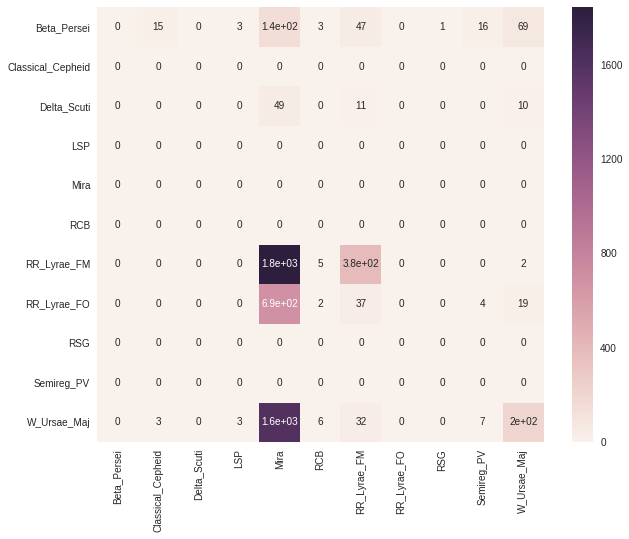

In [16]:
# Plot confusion matrix
conf = confusion_matrix(labels, preds, labels=conf_labels)

cm_df = pd.DataFrame(conf, index=conf_labels, columns=conf_labels)

sns.heatmap(cm_df, annot=True)

## Compute score and plot conf mx for original ASAS model

In [35]:
# Load ASAS science model and do predictions
model = joblib.load('data_no_dups/ASAS_model_compressed.pkl')
preds = model.predict(linear_science_features)
score = np.mean(preds == labels)
print(score)

0.855111452729


['Beta_Lyrae', 'Beta_Persei', 'Classical_Cepheid', 'Delta_Scuti', 'LSP', 'RR_Lyrae_DM', 'RR_Lyrae_FM', 'RR_Lyrae_FO', 'RSG', 'RV_Tauri', 'SARG_B', 'Semireg_PV', 'W_Ursae_Maj', 'Weakline_T_Tauri']


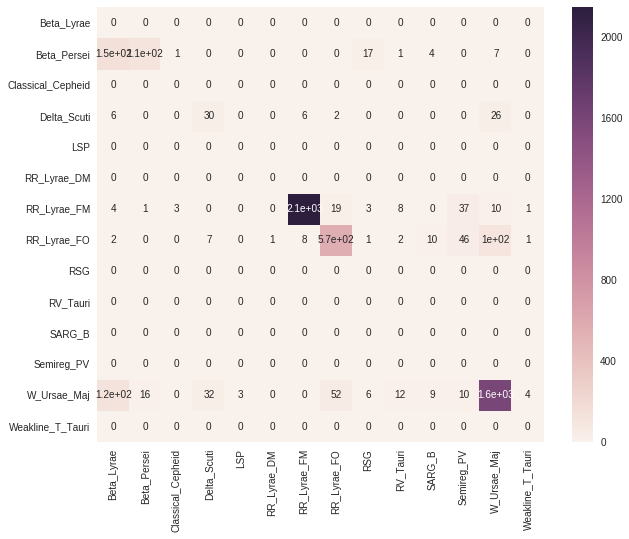

In [18]:
# Sort labels for confusion mx
conf_labels = sorted(list(set(list(labels) + list(preds))))
print(conf_labels)

# Plot confusion matrix
conf = confusion_matrix(labels, preds, labels=conf_labels)

cm_df = pd.DataFrame(conf, index=conf_labels, columns=conf_labels)

sns.heatmap(cm_df, annot=True)

## Plot a real LINEAR LC and a noisified LC

In [21]:
# Load real LINEAR LC
real_linear_LC = pd.read_csv('linear_lcs_formatted/2240118.csv', header=None, names='tme')
real_linear_LC.head()

t       m      e
0  52640.459051  14.470  0.010
1  52667.391095  14.361  0.010
2  52667.405838  14.371  0.010
3  52667.420875  14.396  0.010
4  52667.450575  14.453  0.013

In [32]:
# Load ASAS LC noisified to LINEAR
nsfd_linear_LC = time_series.load('data_no_dups/noisified_LINEAR_lcs/221321_nsfd_to_lc_746028.npz')
nsfd_linear_LC.error
nsfd_linear_df = pd.DataFrame()
nsfd_linear_df['t'] = nsfd_linear_LC.time
nsfd_linear_df['m'] = nsfd_linear_LC.measurement
nsfd_linear_df['e'] = nsfd_linear_LC.error
nsfd_linear_LC = nsfd_linear_df
nsfd_linear_LC.head()

t          m      e
0  52623.401044  18.479510  0.501
1  52623.416337  18.818754  0.459
2  52623.431607  17.412171  0.596
3  52650.292234  17.921480  0.485
4  52650.307654  17.767661  0.462

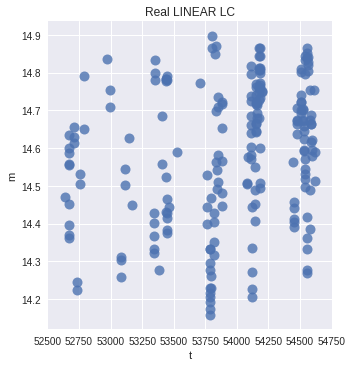

In [33]:
# Plot real LINEAR LC
sns.lmplot('t', 'm', data=real_linear_LC, fit_reg=False, scatter_kws={'marker': 'D', 's': 100})
plt.title('Real LINEAR LC')
plt.xlabel('t')
plt.ylabel('m')

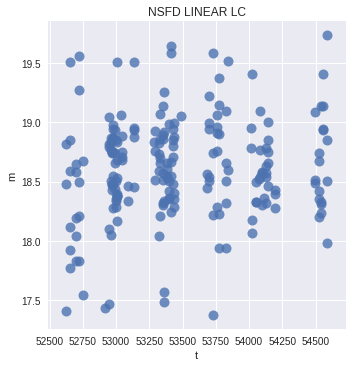

In [34]:
# Plot NSFD LINEAR LC
sns.lmplot('t', 'm', data=nsfd_linear_LC, fit_reg=False, scatter_kws={'marker': 'D', 's': 100})
plt.title('NSFD LINEAR LC')
plt.xlabel('t')
plt.ylabel('m')

## Compare computed periods to human-determined periods

In [5]:
meta = pd.read_csv('linear.meta.csv', usecols=['LINEARobjectID', 'logP']).set_index('LINEARobjectID')
del meta.index.name
meta.head()

logP
29848 -0.254138
32086 -0.244691
50402 -0.191591
61011 -0.178900
62892 -0.275092

In [6]:
linear_science_features, data = featurize.load_featureset('linear_science_features.npz')
linear_science_features.columns = linear_science_features.columns.get_level_values(0)
freqs_periods = linear_science_features[['freq1_freq', 'period_fast']]
try:
    del freqs_periods.index.name
except AttributeError:
    pass
freqs_periods.index = freqs_periods.index.map(int)
freqs_periods['ls_period'] = freqs_periods['freq1_freq'].apply(lambda f: 1.0/f)
freqs_periods = freqs_periods.reindex(meta.index).rename_axis(None, axis=1)
freqs_periods['actual_period'] = meta['logP'].apply(lambda logp: 10.0**logp)
freqs_periods['pct_err_ls'] = np.abs(freqs_periods['actual_period'] - freqs_periods['ls_period']) / freqs_periods['actual_period'] * 100.0
freqs_periods.head()

/home/arien/anaconda3/envs/survey_app2/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


freq1_freq  period_fast  ls_period  actual_period  pct_err_ls
29848    1.795301    16.080851   0.557010       0.557009    0.000128
32086    1.756679    21.141210   0.569256       0.569258    0.000331
50402    1.554468    20.379269   0.643307       0.643293    0.002174
61011    1.509727    70.803950   0.662371       0.662369    0.000335
62892    1.884067    19.623814   0.530767       0.530772    0.000981

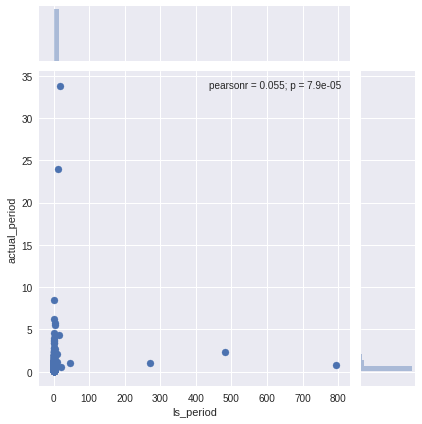

In [8]:
sns.jointplot(freqs_periods['ls_period'], freqs_periods['actual_period'])

In [21]:
# Load original ASAS featureset
asas_fs, asas_data = featurize.load_featureset('data_no_dups/ASAS_features.npz')
asas_fs.columns = asas_fs.columns.get_level_values(0)
# asas_fs.index = asas_fs.index.map(int)
# asas_fs = asas_fs.rename_axis(None, axis=1)
asas_fs.head()

feature  amplitude  flux_percentile_ratio_mid20  flux_percentile_ratio_mid35  \
215707      0.6490                     0.128489                     0.266545   
215727      0.5070                     0.118236                     0.221904   
215728      0.7620                     0.102570                     0.194024   
215737      0.6730                     0.193805                     0.344976   
215738      1.0085                     0.066997                     0.125110   

feature  flux_percentile_ratio_mid50  flux_percentile_ratio_mid65  \
215707                      0.430520                     0.650620   
215727                      0.339660                     0.477776   
215728                      0.302758                     0.451540   
215737                      0.510134                     0.615314   
215738                      0.207395                     0.387275   

feature  flux_percentile_ratio_mid80   max_slope  maximum   median  \
215707                      0.834348    4.150943   12.052  11.5615   
215727                      0.716511  282.186235   13.384  12.7355   
215728                      0.672194  385.483871   13.679  12.6680   
215737                      0.785504    5.937684   12.165  11.7940   
215738                      0.705230  403.984064   13.763  12.2870   

feature  median_absolute_deviation       ...         freq_signif_ratio_31  \
215707                      0.2240       ...                     0.369249   
215727                      0.0655       ...                     0.627223   
215728                      0.0800       ...                     0.764509   
215737                      0.2130       ...                     0.366569   
215738                      0.0680       ...                     0.422913   

feature  freq_varrat  freq_y_offset  linear_trend  medperc90_2p_p  \
215707      0.000040       0.023403     -0.000003        1.093852   
215727      0.000073       0.127756      0.000573        1.088451   
215728      0.000144       0.059574      0.000025        1.089306   
215737      0.000076       0.022272      0.000004        1.233214   
215738      0.000075      -0.002739     -0.000074        1.283705   

feature  p2p_scatter_2praw  p2p_scatter_over_mad  p2p_scatter_pfold_over_mad  \
215707            0.043788              1.580357                    0.191964   
215727            1.000000              0.946565                    0.946565   
215728            2.368810              0.800000                    1.200000   
215737            0.075429              1.652582                    0.300469   
215738            1.000000              0.720588                    0.808824   

feature  p2p_ssqr_diff_over_var  scatter_res_raw  
215707                 2.149561         0.143760  
215727                 0.679154         0.836276  
215728                 0.416580         0.710554  
215737                 2.228361         0.222649  
215738                 0.192218         0.706209  

[5 rows x 70 columns]

In [22]:
# Load noisified featureset
noisified_linear_fs, nsfd_lin_data = featurize.load_featureset('data_no_dups/noisified_LINEAR_features.npz')
noisified_linear_fs.columns = noisified_linear_fs.columns.get_level_values(0)
# noisified_linear_fs.index = noisified_linear_fs.index.map(int)
# noisified_linear_fs = noisified_linear_fs.rename_axis(None, axis=1)
noisified_linear_fs = noisified_linear_fs.reindex(asas_fs.index)
noisified_linear_fs.head()

feature  amplitude  flux_percentile_ratio_mid20  flux_percentile_ratio_mid35  \
215707    1.410285                     0.137884                     0.247600   
215727    1.458392                     0.135038                     0.220773   
215728    1.323913                     0.104896                     0.234053   
215737    1.467505                     0.166523                     0.306193   
215738    1.430983                     0.098038                     0.224250   

feature  flux_percentile_ratio_mid50  flux_percentile_ratio_mid65  \
215707                      0.355286                     0.479402   
215727                      0.329404                     0.461822   
215728                      0.356629                     0.506803   
215737                      0.428616                     0.559808   
215738                      0.361621                     0.473075   

feature  flux_percentile_ratio_mid80   max_slope    maximum     median  \
215707                      0.717922  126.855636  20.034634  18.721510   
215727                      0.767444  134.796005  20.122877  18.621768   
215728                      0.743609  144.012492  19.981043  18.758162   
215737                      0.762060  174.462497  20.306224  18.664612   
215738                      0.670058  198.357139  19.878948  18.675979   

feature  median_absolute_deviation       ...         freq_signif_ratio_31  \
215707                    0.349470       ...                     0.495084   
215727                    0.262354       ...                     0.916154   
215728                    0.275833       ...                     0.897013   
215737                    0.377469       ...                     0.509042   
215738                    0.297170       ...                     0.917958   

feature  freq_varrat  freq_y_offset  linear_trend  medperc90_2p_p  \
215707      0.000419      -0.016806 -5.954560e-05        1.023502   
215727      0.000391       0.000740  1.398409e-07        1.116224   
215728      0.000352      -0.033383 -1.287613e-04        0.999119   
215737      0.000393       0.003377 -6.409633e-05        0.963911   
215738      0.000325       0.003343 -3.777478e-04        0.972971   

feature  p2p_scatter_2praw  p2p_scatter_over_mad  p2p_scatter_pfold_over_mad  \
215707            0.720981              1.376869                    1.146075   
215727            0.864634              1.604133                    1.703163   
215728            1.132498              1.433523                    1.248308   
215737            0.901640              1.095535                    1.011643   
215738            1.135143              1.259977                    1.318467   

feature  p2p_ssqr_diff_over_var  scatter_res_raw  
215707                 1.555539         0.713685  
215727                 2.059301         0.832038  
215728                 1.875706         0.813806  
215737                 1.628059         0.606628  
215738                 1.528312         0.739195  

[5 rows x 70 columns]

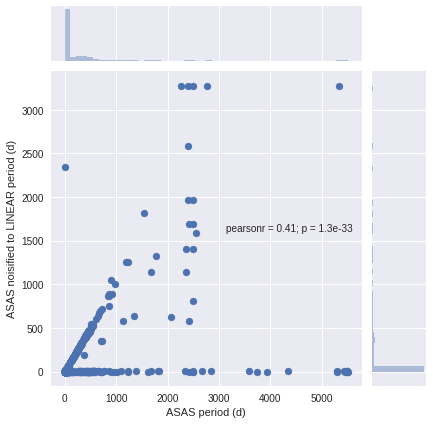

In [35]:
sns.jointplot(asas_fs['freq1_freq'].apply(lambda x: 1.0/x), 
              noisified_linear_fs['freq1_freq'].apply(lambda x: 1.0/x), 
              kind='scatter').set_axis_labels('ASAS period (d)', 'ASAS noisified to LINEAR period (d)')

## Build period-only classifiers

In [54]:
# ASAS
asas_fs, asas_data = featurize.load_featureset('data_no_dups/ASAS_features.npz')
asas_fs.columns = asas_fs.columns.get_level_values(0)

asas_freqs = pd.DataFrame(asas_fs['freq1_freq'])

asas_freqs_model = RandomForestClassifier(n_estimators=1000)
asas_freqs_model.fit(asas_freqs, asas_data['labels'])

preds = asas_freqs_model.predict(pd.DataFrame(linear_science_features['freq1_freq']))
score = np.mean(preds == labels)
print(score)
print(preds)

0.532090699462
['RR_Lyrae_FM' 'RR_Lyrae_FM' 'Delta_Scuti' ..., 'W_Ursae_Maj' 'W_Ursae_Maj'
 'W_Ursae_Maj']


In [53]:
# Noisified to LINEAR
noisified_linear_fs, nsfd_lin_data = featurize.load_featureset('data_no_dups/noisified_LINEAR_features.npz')
noisified_linear_fs.columns = noisified_linear_fs.columns.get_level_values(0)

nsfd_lin_freqs = pd.DataFrame(noisified_linear_fs['freq1_freq'])

nsfd_lin_freqs_model = RandomForestClassifier(n_estimators=1000)
nsfd_lin_freqs_model.fit(nsfd_lin_freqs, nsfd_lin_data['labels'])

preds = nsfd_lin_freqs_model.predict(pd.DataFrame(linear_science_features['freq1_freq']))
score = np.mean(preds == labels)
print(score)
print(preds)

0.375864719447
['RR_Lyrae_FM' 'RSG' 'W_Ursae_Maj' ..., 'W_Ursae_Maj' 'SARG_B' 'SARG_B']


In [52]:
print(data['labels'])
print(asas_data['labels'])

['Mira' 'Delta_Scuti' 'Semireg_PV' 'RR_Lyrae_FM' 'RR_Lyrae_FO'
 'RR_Lyrae_FM' 'RR_Lyrae_FM' 'ChemPeculiar' 'Classical_Cepheid' 'LSP'
 'SARG_B' 'RR_Lyrae_FM' 'RS_CVn' 'RSG' 'RR_Lyrae_FO' 'Semireg_PV' 'RSG'
 'PopII_Cepheid' 'Semireg_PV' 'Beta_Cephei' 'ClassT_Tauri' 'RR_Lyrae_DM'
 'Classical_Cepheid' 'RR_Lyrae_FM' 'LSP' 'Semireg_PV' 'LSP' 'Pulsating_Be'
 'Classical_Cepheid' 'Beta_Cephei' 'RR_Lyrae_FM' 'Mira' 'Classical_Cepheid'
 'W_Ursae_Maj' 'Delta_Scuti' 'ChemPeculiar' 'Weakline_T_Tauri' 'Mira'
 'Semireg_PV' 'Beta_Lyrae' 'Classical_Cepheid' 'RSG' 'SARG_A' 'Beta_Lyrae'
 'Mira' 'Classical_Cepheid' 'Classical_Cepheid' 'RCB' 'Classical_Cepheid'
 'Beta_Lyrae' 'RR_Lyrae_FM' 'Mira' 'RR_Lyrae_FM' 'Semireg_PV' 'LSP'
 'W_Ursae_Maj' 'Mira' 'Mira' 'RR_Lyrae_FM' 'RR_Lyrae_FM' 'RR_Lyrae_FO'
 'RS_CVn' 'W_Ursae_Maj' 'W_Ursae_Maj' 'RSG' 'ChemPeculiar' 'ChemPeculiar'
 'LSP' 'RV_Tauri' 'Semireg_PV' 'LSP' 'Classical_Cepheid' 'LSP' 'Mira'
 'Beta_Lyrae' 'LSP' 'Classical_Cepheid' 'Beta_Persei' 'Semireg_PV'
 '